# Prediction of Optimal Price of AirBnB Listings in New York City
**BrainStation Capstone Project**
- **Author:** Harry Han
- **Date:** 2023/04/09

## Table of Contents

[1. Introduction](#1-introduction)
<br>
[2. Training of regression models](#2-training-of-regression-models)
<br>
[3. Optimal price prediction using XGBoost regressor](#3-optimal-price-prediction-using-xgboost-regressor)
<br>
[4. Conclusions](#4-conclusions)

## 1. Introduction

The nightly price of an AirBnB listing is a critical factor for guests when selecting their accommodations. Hosts need to set the right price to ensure the success of their listings. By analyzing the prices of highly-rated listings, hosts can determine the optimal price for their listings based on factors such as location, maximum number of guests, room type, and Wi-Fi availability. In this notebook, we present regression models that predict the optimal nightly price of AirBnB listings in New York City. Using these models, we provide hosts with a basis for maximizing their revenue based on their specific listing features and conditions.

Our best performing model is the XGBoost Regressor, which predicts that 92% of unhealthy listings in NYC can increase their monthly revenue by an average of $948 if they adjust their price to the optimal level. Our analysis provides insights into various business questions, such as how hosts and guests can determine if a listing is over or underpriced, whether a listing lacks popular amenities compared to similar listings, and why a listing may receive few bookings despite being located in a popular tourist area. We also investigate the effect of each listing feature on the predicted price, enabling hosts to determine where to invest their resources to maximize their revenue.

This notebook is structured as follows: In [Section 2](#2-training-of-regression-models), we load the dataset which was processed in a separate notebook, `1_FeatureEngineering.ipynb`, and train various regression models. In [Section 3](#3-optimal-price-prediction-using-xgboost-regressor), we apply the best performing model, XGBoost regressor, to predict optimal price of healthy and unhealthy listings, and analyze the impact of each listing feature in predicting optimal prices. We take a few examples from overpriced and underpriced unhealthy listings, and see which features make their price not ideal. Finally, we present conclusions in [Section 4](#4-conclusions).

## 2. Training of regression models

First, we import basic libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

And we load the processed training and testing dataset, and separate the input and the target variables. The target variable is `log_price`.

In [2]:
df_train = pd.read_csv('data/airbnb_train.csv')
df_test = pd.read_csv('data/airbnb_test.csv')

X_train = df_train.drop(columns=['log_price'])
y_train = df_train['log_price']
X_test = df_test.drop(columns=['log_price'])
y_test = df_test['log_price']

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (13499, 62)
Shape of X_test: (3375, 62)


There are 13,499 rows in `X_train` and 3,375 rows in `X_test`, which is 80-20 split. We first train a simple linear regression model, and use its testing score as a baseline for our models. As a scoring metric, we use R-squared because it provides a simple measure of the goodness of fit of a regression model. The value of R-squared ranges from 0 to 1, with higher values indicating a better fit.

We build a pipeline which applies a StandardScaler to set the feature scales similar, and a vanila linear regression model. It has no key hyperparameters to be optimized, so we run GridSearchCV without parameter grids and with 5-fold cross-validation.

In [3]:
from sklearn.linear_model import LinearRegression

pipe = Pipeline(steps =[
    ('scaler', StandardScaler()), # Apply standard scaling to the input features
    ('model', LinearRegression())
])
params = {'model__fit_intercept': [True]} # Fix LinearRegression as having an intercept term

grid_search = GridSearchCV(pipe, param_grid=params, cv=5) # Set GridSearchCV with 5-fold cross-validation
fitted_search = grid_search.fit(X_train, y_train) # Fit the GridSearchCV with the data
linreg = fitted_search.best_estimator_ # As default, GridSearchCV has refit=True so this is trained with the entire X_train and y_train
print(linreg)
print(f"Mean cross-validated score of the best_estimator: {round(fitted_search.best_score_, 3)}")
print("Linear Regression R-squared")
print(f"Train score: {round(linreg.score(X_train, y_train), 3)}")
print(f"Test score: {round(linreg.score(X_test, y_test), 3)}")

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])
Mean cross-validated score of the best_estimator: 0.591
Linear Regression R-squared
Train score: 0.597
Test score: 0.584


The testing R-squared of this linear regression model is 0.584, and we use this as the baseline score. Next, we try a Lasso regression. Here, we optimize its `alpha` which controls regularization strength. Zero `alpha` means there is no regularization and gives the same model as a simple linear regression.

In [4]:
from sklearn.linear_model import Lasso

pipe = Pipeline(steps =[
    ('scaler', StandardScaler()), # Apply standard scaling to the input features
    ('model', Lasso())
])
params = {'model__alpha': 10.**np.arange(-3, 4), # Explore alpha values
          'model__max_iter': [8000]} # Set the maximum iteration as 8000

grid_search = GridSearchCV(pipe, param_grid=params, cv=5) # Set GridSearchCV with 5-fold cross-validation
fitted_search = grid_search.fit(X_train, y_train) # Fit the GridSearchCV with the data
lasso = fitted_search.best_estimator_ # As default, GridSearchCV has refit=True so this is trained with the entire X_train and y_train
print(lasso)
print(f"Mean cross-validated score of the best_estimator: {round(fitted_search.best_score_, 3)}")
print("Lasso Regression R-squared")
print(f"Train score: {round(lasso.score(X_train, y_train), 3)}")
print(f"Test score: {round(lasso.score(X_test, y_test), 3)}")

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Lasso(alpha=0.001, max_iter=8000))])
Mean cross-validated score of the best_estimator: 0.591
Lasso Regression R-squared
Train score: 0.596
Test score: 0.584


The testing R-squared of the best Lasso regression is 0.584, which is the same as the baseline score. The optimum `alpha` of 0.001 is small, which indicates that regularization does not help much for the testing score.

We also try Ridge regression, with the optimization of `alpha` again.

In [5]:
from sklearn.linear_model import Ridge

pipe = Pipeline(steps =[
    ('scaler', StandardScaler()), # Apply standard scaling to the input features
    ('model', Ridge())
])
params = {'model__alpha': 10.**np.arange(-3, 4), # Explore alpha values
          'model__max_iter': [8000]} # Set the maximum iteration as 8000

grid_search = GridSearchCV(pipe, param_grid=params, cv=5) # Set GridSearchCV with 5-fold cross-validation
fitted_search = grid_search.fit(X_train, y_train) # Fit the GridSearchCV with the data
ridge = fitted_search.best_estimator_ # As default, GridSearchCV has refit=True so this is trained with the entire X_train and y_train
print(ridge)
print(f"Mean cross-validated score of the best_estimator: {round(fitted_search.best_score_, 3)}")
print("Ridge Regression R-squared")
print(f"Train score: {round(ridge.score(X_train, y_train), 3)}")
print(f"Test score: {round(ridge.score(X_test, y_test), 3)}")

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Ridge(alpha=100.0, max_iter=8000))])
Mean cross-validated score of the best_estimator: 0.591
Ridge Regression R-squared
Train score: 0.597
Test score: 0.584


The testing R-squared of the best Ridge regression is 0.584, which is the same as the baseline score. This time, the optimum `alpha` of 100 is large, but the regularization does not seem to improve the testing score much from the baseline.

Next, we try ElasticNet which is a hybrid of Lasso and Ridge regression. The ratio between the L1 and L2 regularization term is determined by `l1_ratio` parameter, which is optimized together with `alpha`. Due to a long computation time, the training was run from a separate script called `train.py` which is run by a shell script `run_train.sh`. Here we load the saved model as well as its cross validation score.

In [6]:
from sklearn.linear_model import ElasticNet
import joblib

enet, best_cv_score = joblib.load('model/enet.joblib') # Load the saved model and the best cross validation score
print(enet)
print(f"Mean cross-validated score of the best_estimator: {round(best_cv_score, 3)}")
print("ElasticNet Regression R-squared")
print(f"Train score: {round(enet.score(X_train, y_train), 3)}")
print(f"Test score: {round(enet.score(X_test, y_test), 3)}")

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 ElasticNet(alpha=0.001, l1_ratio=0.4, max_iter=8000))])
Mean cross-validated score of the best_estimator: 0.591
ElasticNet Regression R-squared
Train score: 0.597
Test score: 0.584


The scores are similar with the previous models. Thus, linear models, regardless of a regularization term, do not fit well on the dataset.

Now we move on to tree ensemble models. We try a RandomForestRegressor, which trains multiple decision trees on different subsets of the input data and features, and then combines their predictions through an averaging process. We optimized the number of trees as well as the maximum tree depth. As it is a tree model, scalar was not used. It was also trained in `train.py`, and the saved file is near 1.5G because the best model has 1,500 trees with a maximum depth of 800. The trained model can be downloaded from [here](https://drive.google.com/drive/folders/13rB85yxetKdj31Yjqcy6mBW7utoRH8zR?usp=share_link), but we comment out the cell below in case when the file is not downloaded.

In [7]:
'''
from sklearn.ensemble import RandomForestRegressor

rfr, best_cv_score = joblib.load('model/rfr.joblib') # Load the saved model and the best cross validation score
print(rfr)
print(f"Mean cross-validated score of the best_estimator: {round(best_cv_score, 3)}")
print("Random Forest Regression R-squared")
print(f"Train score: {round(rfr.score(X_train, y_train), 3)}")
print(f"Test score: {round(rfr.score(X_test, y_test), 3)}")
'''

Pipeline(steps=[('model',
                 RandomForestRegressor(max_depth=800, n_estimators=1500))])
Mean cross-validated score of the best_estimator: 0.732
Random Forest Regression R-squared
Train score: 0.965
Test score: 0.723


The R-squared is 0.965 for the training data and 0.723 for the testing data, which is higher than the baseline R-squared of 0.584. Regarding 1,500 trees with 800 maximum depth, the model might be too complex and seems to suffer from overfitting. But still, it performs better than the linear models.

Lastly, we try XGBoost (eXtreme Gradient Boosting) Regression model which implements gradient boosting and is able to capture complex nonlinear relationships between features and target variables. Like the RandomForestRegressor, scalar was not used and we optimized the number of trees as well as the maximum tree depth. It was also trained in `train.py`.

In [8]:
from xgboost import XGBRegressor

xgb, best_cv_score = joblib.load('model/xgb.joblib') # Load the saved model and the best cross validation score
print(xgb)
print(f"Mean cross-validated score of the best_estimator: {round(best_cv_score, 3)}")
print("XGBoost Regression R-squared")
print(f"Train score: {round(xgb.score(X_train, y_train), 3)}")
print(f"Test score: {round(xgb.score(X_test, y_test), 3)}")

Pipeline(steps=[('model',
                 XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.1, max_bin=256,
                              max_cat_to_onehot=4, max_delta_step=0,
                              max_depth=6, max_leaves=0, min_child_weight=1,
                              missing=nan, monotone_constraints='()',
                              n_estimators=400, n_jobs=0, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, ...))])
Mean cross-validated score of 

The best model has 400 weak learner trees with a maximum depth of 6, which gives R-squared of 0.907 for the training data and 0.733 for the testing data. The testing score is slightly better with slightly less overfitting compared to the RandomForestRegressor.

We summarize the result from the models in the table below.

| **Model**                | **Training R-squared** | **Testing R-squared** |
|--------------------------|------------------------|-----------------------|
| Linear Regression        | 0.597                  | 0.584                 |
| Lasso Regression         | 0.596                  | 0.584                 |
| Ridge Regression         | 0.597                  | 0.584                 |
| ElasticNet               | 0.597                  | 0.584                 |
| Random Forest Regression | 0.965                  | 0.723                 |
| XGBoost Regression       | 0.907                  | 0.733                 |

## 3. Optimal price prediction using XGBoost regressor

In this section, we use our best model, XGBoost regressor, to predict optimal prices of AirBnB listings. We will predict optimal prices of unhealthy listings which were separated in the feature engineering part, and analyze the expected increase of revenue for the price adjustment. Before we move on to the unhealthy listings data, we investigate the result of XGBoost on the training and testing data, which are for healthy listings.

We can first check the normality of residuals from XGBoost regressor. This is not necessary as it is not a linear regression model, but it is worth to ensure the validity and reliability of the model. Normality of residuals indicates that the model's errors are randomly distributed and that the model is capturing the systematic patterns in the data.

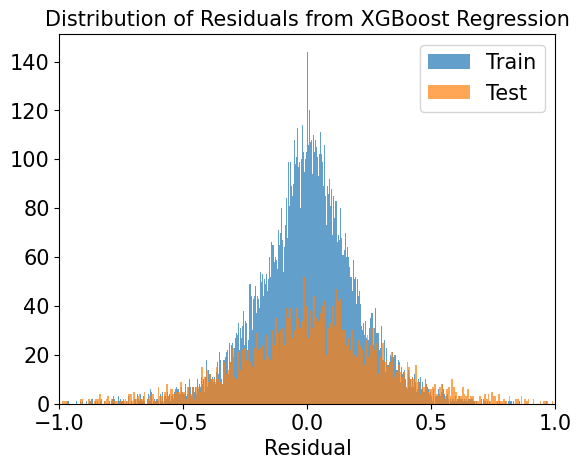

In [9]:
log_price_train_true = y_train
log_price_train_pred = xgb.predict(X_train)
log_price_test_true = y_test
log_price_test_pred = xgb.predict(X_test)

plt.figure()
plt.title("Distribution of Residuals from XGBoost Regression", fontsize=15)
plt.hist(log_price_train_pred - log_price_train_true, bins=1000, alpha=0.7, label="Train")
plt.hist(log_price_test_pred - log_price_test_true, bins=1000, alpha=0.7, label="Test")
plt.xlabel('Residual', fontsize=15)
plt.xlim(left=-1., right=1.)
plt.legend(fontsize=15)
plt.tick_params('both', labelsize=15)
plt.show()

The above histogram shows that the residuals seem to be normally distributed for both training and testing data. Thus, XGBoost regressor tends to capture the underlying pattern in the dataset well.

Next, we use SHAP (SHapley Additive exPlanations) on the XGBoost regressor to interpret the impact of individual features on the model's predictions, and to gain insight into how the model arrives at its decisions. For this, we fit a tree-specific explainer to the XGBoost regressor, and obtain SHAP values for the training data of healthy listings.

In [10]:
import shap

# Fit tree-specific kernel for SHAP  
explainer = shap.TreeExplainer(xgb['model'])

# Obtain SHAP values
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


We visualize these SHAP values as below. First, we use bar type summary plot to show top 10 features with the most impact.

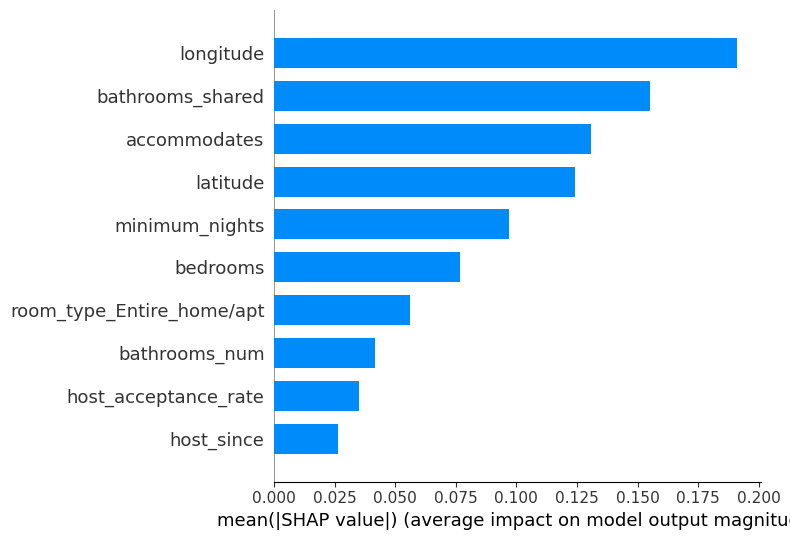

In [11]:
# Global interpretation - summary plot - type='bar'
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar', max_display=10, show=False)
plt.savefig('figures/shap_bar_10.pdf')
plt.show()

We also save the top 5 version for our convenience.

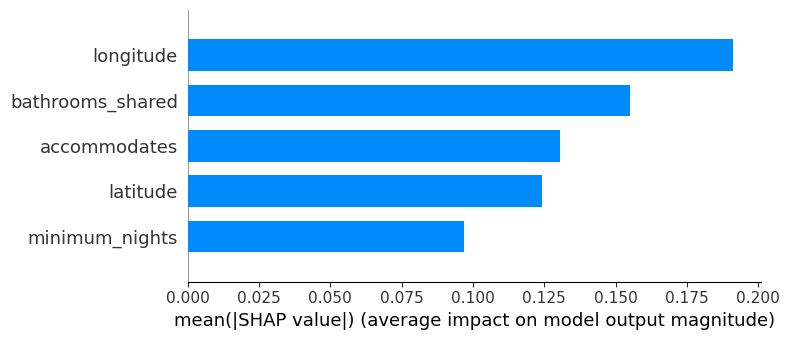

In [12]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar', max_display=5, show=False)
plt.savefig('figures/shap_bar_5.pdf')
plt.show()

`longitude` has the most impact on the model output, followed by `bathrooms_shared`, `accommodates`, `latitude`, and so on. We can check the direction of impact from each feature by drawing a dot type summary plot as below.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


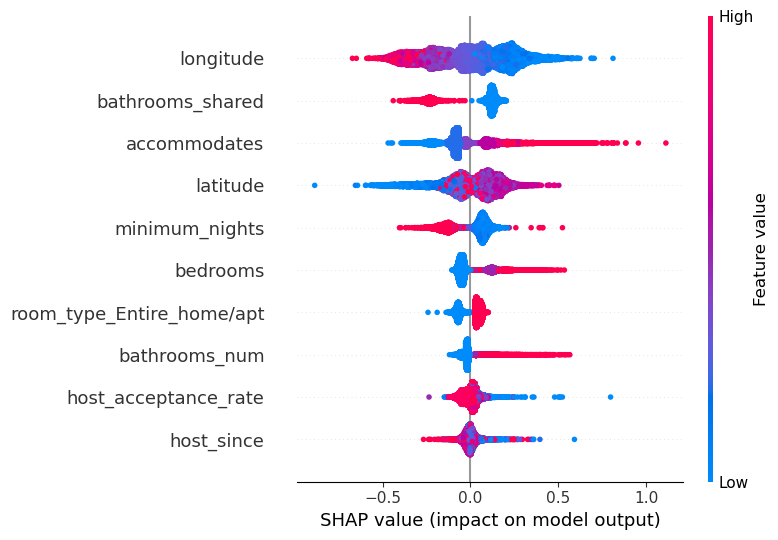

In [13]:
# Global interpretation - summary plot - type = 'dot'
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, max_display=10, show=False)
plt.savefig('figures/shap_dot_10.pdf')
plt.show()

Smaller `longitude` and larger `latitude` tend to give a higher listing price, and vice versa. This means that listings located in downtown area of lower Manhattan compared to the listings in Queens. Thus, geographical factor of listings has the most impact to the optimal price prediction by the XGBoost regressor. Another impactful factor is `bathrooms_shared`, where its False gives a higher listing price, and vise versa. This makes sense as guests tend to prefer listings where bathrooms are not shared with others, leading to a higher price for such listings. Listings with more number of `accommodates`, `bedrooms`, and `bathrooms_num` are more expensive, which also makes sense. Except a few outliers, listings with smaller `minimum_nights` tend to have a higher price than listings which accept longer minimum stays. Listings having `room_type_Entire_home/apt` as True are more expensive, which is reasonable. Listings with smaller `host_acceptance_rate` is more expensive, which might be because the hosts become more picky in accepting bookings if their listings are expensive. `host_since` is relatively less clear in the direction of feature values. Overall, the insights gained from SHAP values on healthy listings make sense.

Now, we apply the XGBoost regressor on the unhealthy listings data to see if they are overpriced or underpriced. We first load this data which was saved in the feature engineering.

In [14]:
df_unhealthy = pd.read_csv('data/airbnb_unhealthy.csv', index_col=0)

Then, we take the true `log_price` of these unhealthy listings, as well as the predicted log-price from the XGBoost regressor. We set a residual as their difference.

In [15]:
unhealthy_log_price_true = df_unhealthy['log_price']
unhealthy_log_price_pred = xgb.predict(df_unhealthy.drop(columns=['log_price']))
residual_log_price = unhealthy_log_price_pred - unhealthy_log_price_true

We check the homoscedasticity in the residuals by plotting them against the predicted listing log-price.

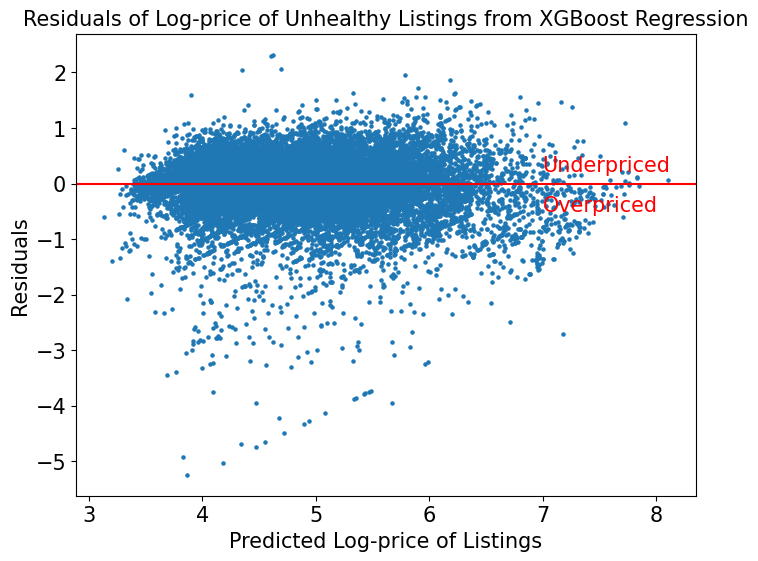

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(unhealthy_log_price_pred, residual_log_price, s=5)
plt.axhline(0., c='r')
plt.text(7., 0.5, "Underpriced", fontsize=15, c='r', va='top')
plt.text(7., -0.5, "Overpriced", fontsize=15, c='r')
plt.xlabel('Predicted Log-price of Listings', fontsize=15)
plt.ylabel('Residuals', fontsize=15)
plt.title('Residuals of Log-price of Unhealthy Listings from XGBoost Regression', fontsize=15)
plt.tick_params('both', labelsize=15)
plt.show()

The residuals seem to be fairly homoscedastic. Thus, XGBoost regressor tends to capture the underlying pattern in the unseen unhealthy dataset well.

This is the residual of log-price. To see the residual of the actual price, we exponentiate the true log-price as well as the predicted log-price.

In [17]:
unhealthy_price_true = np.exp(unhealthy_log_price_true) # True price of unhealthy listings
unhealthy_price_pred = np.exp(unhealthy_log_price_pred) # Predicted price of unhealthy listings
residual_price = unhealthy_price_pred - unhealthy_price_true

We check the homoscedasticity in the residuals by plotting them against the predicted listing price.

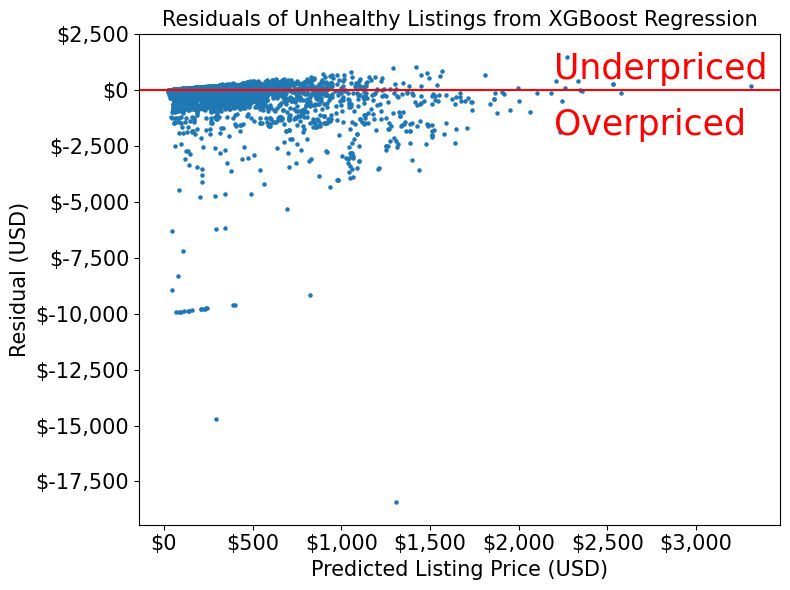

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(unhealthy_price_pred, residual_price, s=5)
plt.axhline(0., c='r')
plt.text(2200., 500., "Underpriced", fontsize=25, c='r')
plt.text(2200., -2000., "Overpriced", fontsize=25, c='r')
plt.xlabel('Predicted Listing Price (USD)', fontsize=15)
plt.ylabel('Residual (USD)', fontsize=15)
plt.title('Residuals of Unhealthy Listings from XGBoost Regression', fontsize=15)
plt.tick_params('both', labelsize=15)
# Set format of xticks and yticks as dollar
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.savefig('figures/residual.pdf')
plt.show()

The percentage of the overpriced unhealthy listings is shown below.

In [19]:
perc_overpriced_unhealthy = len(df_unhealthy.loc[residual_price < 0., :])/len(df_unhealthy)*100.
print(f"Percentage of Overpriced Unhealthy Listings: {round(perc_overpriced_unhealthy, 2)} %")

Percentage of Overpriced Unhealthy Listings: 49.37 %


Thus, there are similar number of overpriced and underpriced unhealthy listings. Also, there are a few listings which are very much overpriced with residuals near \$-15,000 or \$-18,000. Compared to the residuals of the log-price, the outliers are exaggerated from the exponentiation. We take a closer look at such listings with residuals less than $-9,000, by taking their information from the raw data.

In [20]:
# Read the raw dataset
df_raw = pd.read_csv('data/listings.csv')
# Add a column 'price_num' which is 'price' converted to numeric
df_raw['price_num'] = df_raw['price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
# Get indices of abnormal listings with residuals less than -9000
idx_abnormal = df_unhealthy.loc[residual_price < -9000, :].index
# Get rows of idx_abnormal in the raw dataframe, and sort by 'price_num'. Show the listing_url and its price.
df_raw.iloc[idx_abnormal].sort_values(by='price_num', ascending=False)[['listing_url', 'price']]

Columns (68) have mixed types. Specify dtype option on import or set low_memory=False.


,listing_url,price
32874,https://www.airbnb.com/rooms/603665411466936794,"$19,750.00"
34965,https://www.airbnb.com/rooms/658503812592195974,"$15,000.00"
2921,https://www.airbnb.com/rooms/4251721,"$10,000.00"
8642,https://www.airbnb.com/rooms/13925864,"$10,000.00"
12777,https://www.airbnb.com/rooms/22436899,"$10,000.00"
16423,https://www.airbnb.com/rooms/31219800,"$10,000.00"
19365,https://www.airbnb.com/rooms/38993493,"$10,000.00"
19367,https://www.airbnb.com/rooms/38993556,"$10,000.00"
19369,https://www.airbnb.com/rooms/38993679,"$10,000.00"
19750,https://www.airbnb.com/rooms/39574087,"$10,000.00"


The high prices of these abnormal listings seem to be set arbitrarily. We verify this by checking the actual listing pages of the top 3 most expensive unhealthy listings.

In [21]:
from IPython.display import display, HTML

# HTML of listings were obtained from Share -> Embed feature in the listing page.
listing_1 = '<div class="airbnb-embed-frame" data-id="603665411466936794" data-view="home" style="width:450px;height:300px;margin:auto"><a href="https://www.airbnb.com/rooms/603665411466936794?guests=1&amp;adults=1&amp;s=66&amp;source=embed_widget">View On Airbnb</a><a href="https://www.airbnb.com/rooms/603665411466936794?guests=1&amp;adults=1&amp;s=66&amp;source=embed_widget" rel="nofollow">New York Estate</a><script async="" src="https://www.airbnb.com/embeddable/airbnb_jssdk"></script></div>'
listing_2 = '<div class="airbnb-embed-frame" data-id="658503812592195974" data-view="home" style="width:450px;height:300px;margin:auto"><a href="https://www.airbnb.com/rooms/658503812592195974?guests=1&amp;adults=1&amp;s=66&amp;source=embed_widget">View On Airbnb</a><a href="https://www.airbnb.com/rooms/658503812592195974?guests=1&amp;adults=1&amp;s=66&amp;source=embed_widget" rel="nofollow">Big 2 bedroom two bathroom in a doorman building.</a><script async="" src="https://www.airbnb.com/embeddable/airbnb_jssdk"></script></div>'
listing_3 = '<div class="airbnb-embed-frame" data-id="4251721" data-view="home" style="width:450px;height:300px;margin:auto"><a href="https://www.airbnb.com/rooms/4251721?guests=1&amp;adults=1&amp;s=66&amp;source=embed_widget">View On Airbnb</a><a href="https://www.airbnb.com/rooms/4251721?guests=1&amp;adults=1&amp;s=66&amp;source=embed_widget" rel="nofollow">Nice Quiet Bedroom w/ Pretty View</a><script async="" src="https://www.airbnb.com/embeddable/airbnb_jssdk"></script></div>'

display(HTML(listing_1), HTML(listing_2), HTML(listing_3))

In these listings, there seem no justifications for such high nightly prices. These prices might be just placeholders.

Next, we estimate the current revenue as well as the expected revenue when the price is adjusted to the optimal price. As a measure of revenue, we use RevPAR which stands for Revenue per Available Room. It is a commonly used performance metric in the hospitality industry, particularly for hotels and resorts. In our case, monthly RevPAR is calculated by multiplying the nightly price by the total number of booked days during 30 days (i.e. `price` X (30 - `availability_30`)). For this, we first load the availability dataframe of the unhealthy listings which was saved in the feature engineering.

In [22]:
df_unhealthy_availabilities = pd.read_csv('data/airbnb_availabilities_unhealthy.csv', index_col=0)

At the end of Section 6 of `1_FeatureEngineering.ipynb`, we concluded that unhealthy listings will effectively have 5 less available days if they adjust their price to the optimal price predicted by the model trained with data from healthy listings. Therefore, for the booked days of the adjusted listings, we add 5 more booked days to the current booked days.

Also, as discussed in the feature engineering, zero `availability_30` does not necessarily mean that the listing is very popular, but it is likely that the host just disabled booking in the next 30 days. Thus, we set these cases as zero booked days, not 30 booked days.

In [23]:
booked_days_30_current = 30 - df_unhealthy_availabilities['availability_30']
booked_days_30_current[df_unhealthy_availabilities['availability_30'] == 0] = 0

booked_days_30_optimal = booked_days_30_current + 5
booked_days_30_optimal.clip(upper=30, inplace=True) # Clip at 30 if adding 5 exceeds 30

Now the current and optimal monthly RevPAR, as well as their difference, are computed below.

In [24]:
df_unhealthy['current_price'] = unhealthy_price_true
df_unhealthy['optimal_price'] = unhealthy_price_pred
df_unhealthy['RevPAR_current'] = df_unhealthy['current_price'] * booked_days_30_current
df_unhealthy['RevPAR_optimal'] = df_unhealthy['optimal_price'] * booked_days_30_optimal
df_unhealthy['RevPAR_diff'] = df_unhealthy['RevPAR_optimal'] - df_unhealthy['RevPAR_current']

We draw a box plot of `RevPAR_diff` as below.

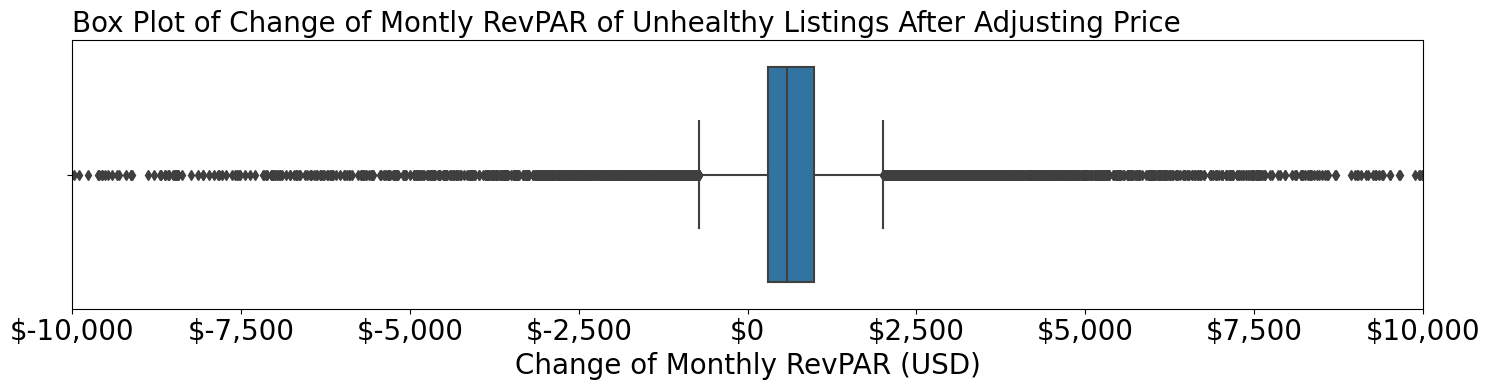

In [25]:
plt.figure(figsize=(15, 4))
sns.boxplot(x=df_unhealthy['RevPAR_diff'])
plt.xlim(left=-10000., right=10000.)
plt.tick_params('x', labelsize=20)
plt.xlabel('Change of Monthly RevPAR (USD)', fontsize=20)
plt.title('Box Plot of Change of Montly RevPAR of Unhealthy Listings After Adjusting Price', fontsize=20, loc='left')
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
plt.tight_layout()
plt.savefig('figures/box_revpar.pdf')
plt.show()

The box plot indicates that most of unhealthy listings will have a positive change of RevPAR if they adjust their price to the optimal value. Specifically, the percentage of listings with positive `RevPAR_diff`, and their mean `RevPAR_diff`, are as below.

In [26]:
perc_profit_optimal_price = len(df_unhealthy.loc[df_unhealthy['RevPAR_diff'] > 0., :])/len(df_unhealthy)*100.
avg_profit = df_unhealthy.loc[df_unhealthy['RevPAR_diff'] > 0., 'RevPAR_diff'].mean()
print("{0} % of Unhealthy Listings Expect Increase of Monthly RevPAR by ${1:,.0f} in Average.".format(round(perc_profit_optimal_price, 2), avg_profit))

92.19 % of Unhealthy Listings Expect Increase of Monthly RevPAR by $948 in Average.


92.19 % of unhealthy listings expect an increase of their monthly RevPAR by $948 in average. Therefore, our XGBoost regressor is beneficial in terms of the revenue to the most of unhealthy listings in NYC.

Next, we investigate two examples of overpriced unhealthy listings and one example of underpriced unhealthy listing, and see which features make them overpriced or underpriced using a force plot. We start by taking overpriced listings with `RevPAR_diff` in the range of (900, 1500).

In [27]:
df_unhealthy_examples = df_unhealthy.loc[
    (df_unhealthy['RevPAR_diff'] > 900.) & 
    (df_unhealthy['RevPAR_diff'] < 1500.) &
    (df_unhealthy['optimal_price'] < df_unhealthy['current_price']), :] # Take overpriced listings
df_raw.iloc[df_unhealthy_examples.index][['listing_url', 'price', 'availability_30']]

,listing_url,price,availability_30
2,https://www.airbnb.com/rooms/5136,$275.00,0
104,https://www.airbnb.com/rooms/103311,$599.00,20
131,https://www.airbnb.com/rooms/53477,$350.00,0
247,https://www.airbnb.com/rooms/149287,$250.00,0
293,https://www.airbnb.com/rooms/166006,$250.00,0
...,...,...,...
41441,https://www.airbnb.com/rooms/773314357723785594,$322.00,30
41442,https://www.airbnb.com/rooms/773314804331716702,"$1,500.00",30
41453,https://www.airbnb.com/rooms/773409344998891021,$346.00,24
41490,https://www.airbnb.com/rooms/772513958238098796,$228.00,29


Let's select a listing at the index of 1209 as an example, and show its information in the raw dataframe.

In [28]:
idx_example = 1209
df_raw.iloc[df_unhealthy_examples.index][['listing_url', 'price', 'availability_30']].iloc[[idx_example]]

,listing_url,price,availability_30
34501,https://www.airbnb.com/rooms/649470584792583345,$399.00,29


This listing has a nightly price of $399, and 29 days are available to book in the next 30 days. The listing page is shown below.

In [29]:
listing = '<div class="airbnb-embed-frame" data-id="649470584792583345" data-view="home" style="width:450px;height:300px;margin:auto"><a href="https://www.airbnb.com/rooms/649470584792583345?guests=1&amp;adults=1&amp;s=66&amp;source=embed_widget">View On Airbnb</a><a href="https://www.airbnb.com/rooms/649470584792583345?guests=1&amp;adults=1&amp;s=66&amp;source=embed_widget" rel="nofollow">Perfect Chill Spot in Flatbush</a><script async="" src="https://www.airbnb.com/embeddable/airbnb_jssdk"></script></div>'
display(HTML(listing))

It currently has only 5 reviews with 4 stars.

In [30]:
print("Optimal Price: ${0:,.0f}".format(df_unhealthy_examples['optimal_price'].iloc[idx_example]))
print("Increase of RevPAR: ${0:,.0f}".format(df_unhealthy_examples['RevPAR_diff'].iloc[idx_example]))

Optimal Price: $282
Increase of RevPAR: $1,293


If this listing lowers its price to the optimal price, $282, it can expect an increase of RevPAR by $1,293. Let's draw a force plot from the SHAP values using a custom function defined below.

In [31]:
def draw_force_plot(explainer, df, idx):
    '''
    Plot SHAP values for row at index idx
    Input
        explainer (shap.TreeExplainer): a SHAP explainer for tree models
        df (pandas DataFrame): a DataFrame to be used for SHAP values
        idx (int): index of interest
    '''
    shap_values = explainer.shap_values(df)
    shap.force_plot(explainer.expected_value,  # Plots the average prediction on the plot
                shap_values[idx],              # Plots the Shapley values on the force plot 
                features=df.iloc[idx],         # 'features' displays the value that is passed to it on the plot; feature value plotted for easier interpretation
                feature_names=df.columns,      # 'feature_names' displays the name of the features
                matplotlib=True,
                show=False)

Now we give arguments to `draw_force_plot` and draw a force plot of this listing.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


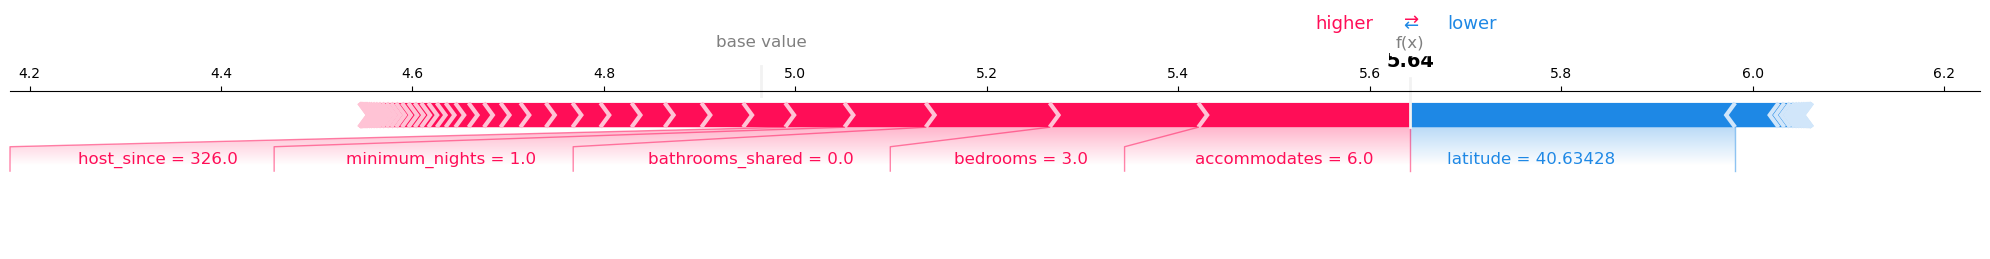

In [32]:
# To compute SHAP values of these examples, drop columns that are not used by XGBoost regressor
df_unhealthy_examples_input = df_unhealthy_examples.drop(
    columns=['log_price', 'current_price', 'optimal_price', 'RevPAR_current', 'RevPAR_optimal', 'RevPAR_diff'], errors='ignore'
    )
draw_force_plot(explainer, df_unhealthy_examples_input, idx_example)
plt.tight_layout()
plt.savefig('figures/shap_example_1.pdf')
plt.show()

This indicates that although the listing's high number of accommodates, bedrooms, and non-shared baths can push its predicted price to higher, the impact of its latitude is so strong, making it overpriced. Indeed, this listing is located in the lower part of Brooklyn where the listing prices are relatively lower than the area of Manhattan. Thus, XGBoost regressor recommends to lower the price regarding its location to maximize the revenue. This observation is reflected in its scores as below.

In [33]:
col_scores = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',\
               'review_scores_communication', 'review_scores_location', 'review_scores_value']
df_raw.iloc[df_unhealthy_examples.index][col_scores].iloc[[idx_example]]

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
34501,4.2,4.4,3.8,4.2,4.4,3.6,4.2


Indeed, its review score for location is the lowest than the other scores. Thus, guests tend to dislike the location of this listing more than the other factors.

Let's take a look at another example of the overpriced unhealthy listing. We select a listing at the index of 221 as an example, and show its information in the raw dataframe.

In [34]:
idx_example = 221
df_raw.iloc[df_unhealthy_examples.index][['listing_url', 'price', 'availability_30']].iloc[[idx_example]]

,listing_url,price,availability_30
7344,https://www.airbnb.com/rooms/11790578,$245.00,8


This listing has a nightly price of $245, and 8 days are available to book in the next 30 days. The listing page is shown below.

In [35]:
listing = '<div class="airbnb-embed-frame" data-id="11790578" data-view="home" style="width:450px;height:300px;margin:auto"><a href="https://www.airbnb.com/rooms/11790578?guests=1&amp;adults=1&amp;s=66&amp;source=embed_widget">View On Airbnb</a><a href="https://www.airbnb.com/rooms/11790578?guests=1&amp;adults=1&amp;s=66&amp;source=embed_widget" rel="nofollow">A quiet house in a Fabulous Neighborhood</a><script async="" src="https://www.airbnb.com/embeddable/airbnb_jssdk"></script></div>'
display(HTML(listing))

It currently has 16 reviews with 4.44 stars.

In [36]:
print("Optimal Price: ${0:,.0f}".format(df_unhealthy_examples['optimal_price'].iloc[idx_example]))
print("Increase of RevPAR: ${0:,.0f}".format(df_unhealthy_examples['RevPAR_diff'].iloc[idx_example]))

Optimal Price: $233
Increase of RevPAR: $907


If this listing lowers its price to the optimal price, $233, it can expect an increase of RevPAR by $907. Let's draw a force plot from the SHAP values using a custom function defined below.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


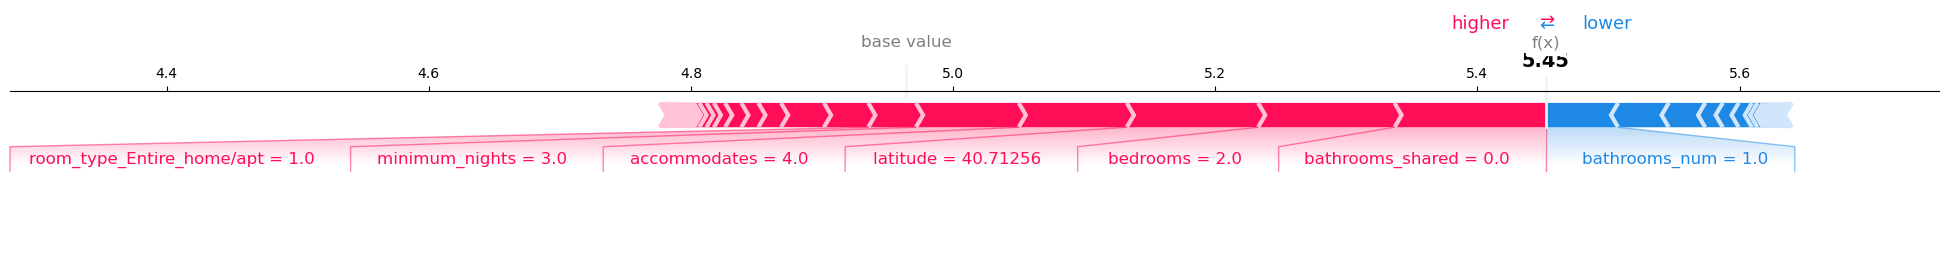

In [37]:
draw_force_plot(explainer, df_unhealthy_examples_input, idx_example)
plt.tight_layout()
plt.savefig('figures/shap_example_1.pdf')
plt.show()

This indicates that although the listing's non-shared baths, 2 bedrooms, and its latitude can push its predicted price to higher, the impact of only one bathroom is so strong, making it overpriced. The host may consider increasing the number of bath, if possible, to justify its price. It is located in the upper part of Brooklyn close to Manhattan which is attractive to the tourists. This observation is reflected in its scores as below.

In [38]:
df_raw.iloc[df_unhealthy_examples.index][col_scores].iloc[[idx_example]]

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
7344,4.54,4.69,4.08,4.77,4.77,4.92,4.46


Indeed, its review score for location is the highest than the other scores. Thus, guests tend to like the location of this listing more than the other factors.

We move on to an example of underpriced unhealthy listing. We take underpriced listings with `RevPAR_diff` in the range of (1500, 2100).

In [39]:
df_unhealthy_examples = df_unhealthy.loc[
    (df_unhealthy['RevPAR_diff'] > 1500.) & 
    (df_unhealthy['RevPAR_diff'] < 2100.) &
    (df_unhealthy['optimal_price'] > df_unhealthy['current_price']), :] # Take underpriced listings
df_raw.iloc[df_unhealthy_examples.index][['listing_url', 'price', 'availability_30']]

,listing_url,price,availability_30
32,https://www.airbnb.com/rooms/15341,$213.00,19
52,https://www.airbnb.com/rooms/36934,$150.00,2
62,https://www.airbnb.com/rooms/64837,$80.00,4
162,https://www.airbnb.com/rooms/74333,$100.00,12
187,https://www.airbnb.com/rooms/80493,$58.00,2
...,...,...,...
41455,https://www.airbnb.com/rooms/773409373273499444,$346.00,24
41472,https://www.airbnb.com/rooms/773411792567687344,$79.00,11
41477,https://www.airbnb.com/rooms/772484858761059693,$81.00,18
41523,https://www.airbnb.com/rooms/772607042480055880,$163.00,18


Let's select a listing at the index of 2 as an example, and show its information in the raw dataframe.

In [40]:
idx_example = 2
df_raw.iloc[df_unhealthy_examples.index][['listing_url', 'price', 'availability_30']].iloc[[idx_example]]

,listing_url,price,availability_30
62,https://www.airbnb.com/rooms/64837,$80.00,4


This listing has a nightly price of $80, and 4 days are available to book in the next 30 days. The listing page is shown below.

In [41]:
listing = '<div class="airbnb-embed-frame" data-id="64837" data-view="home" style="width:450px;height:300px;margin:auto"><a href="https://www.airbnb.com/rooms/64837?guests=1&amp;adults=1&amp;s=66&amp;source=embed_widget">View On Airbnb</a><a href="https://www.airbnb.com/rooms/64837?guests=1&amp;adults=1&amp;s=66&amp;source=embed_widget" rel="nofollow">ENJOY Downtown NYC!!</a><script async="" src="https://www.airbnb.com/embeddable/airbnb_jssdk"></script></div>'
display(HTML(listing))

It currently has 263 reviews with 4.58 stars.

In [42]:
print("Optimal Price: ${0:,.0f}".format(df_unhealthy_examples['optimal_price'].iloc[idx_example]))
print("Increase of RevPAR: ${0:,.0f}".format(df_unhealthy_examples['RevPAR_diff'].iloc[idx_example]))

Optimal Price: $139
Increase of RevPAR: $2,082


If this listing lowers its price to the optimal price, $139, it can expect an increase of RevPAR by $2,082. Let's draw a force plot from the SHAP values using a custom function defined below.

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


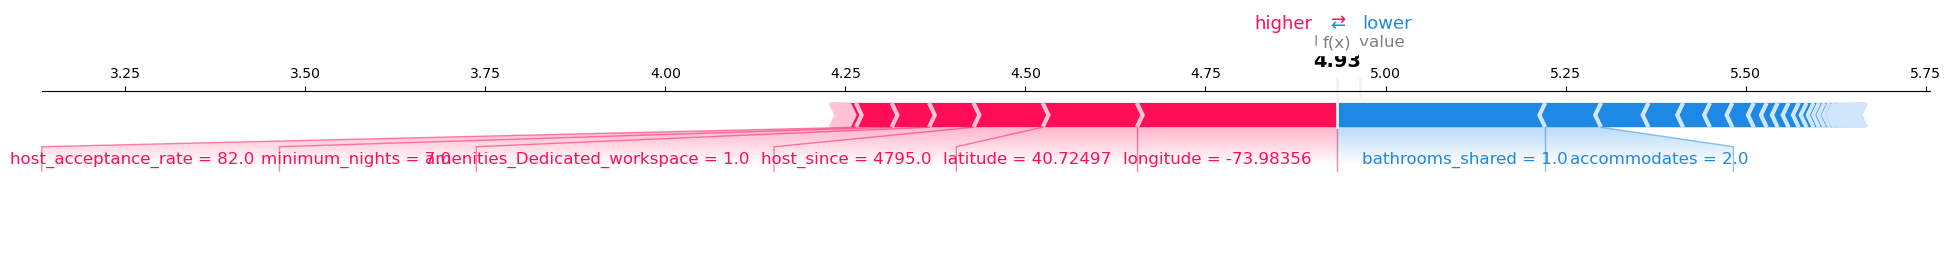

In [43]:
# To compute SHAP values of these examples, drop columns that are not used by XGBoost regressor
df_unhealthy_examples_input = df_unhealthy_examples.drop(
    columns=['log_price', 'current_price', 'optimal_price', 'RevPAR_current', 'RevPAR_optimal', 'RevPAR_diff'], errors='ignore'
    )
draw_force_plot(explainer, df_unhealthy_examples_input, idx_example)
plt.tight_layout()
plt.savefig('figures/shap_example_1.pdf')
plt.show()

This indicates that although the listing's shared baths and 2 accommodations can push its predicted price to lower, the impact of its longitude and latitude is so strong, making it underpriced. Indeed, it is located in the lower Manhattan which is attractive to the tourists. The host can benefit from its great location by increasing its price. This observation is reflected in its scores as below.

In [44]:
df_raw.iloc[df_unhealthy_examples.index][col_scores].iloc[[idx_example]]

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
62,4.58,4.73,4.2,4.78,4.88,4.82,4.61


Indeed, its review score for location is very high compared to the other scores. Thus, guests tend to like the location of this listing more than the other factors.

All in all, the results from analysis of unhealthy listings are reasonable, for both overpriced and underpriced cases.

## 4. Conclusions

We trained regression models on a dataset of healthy listings in NYC with high number of reviews and high scores, and XGBoost regressor performs the best in the testing data. According to the analysis of the impact of features, location of the listing has the most impact on the price prediction, followed by having a shared bathroom, number of accommodations, etc. It was shown that 92 % of unhealthy listings expect an increase of their monthly Revenue per Available Room (RevPAR) by $948 in average. The analysis of examples from overpriced and underpriced unhealthy listings provides ideas to the host about why the prices are not ideal, and where to invest resources to maximize their revenue. Our model will be a useful tool for both hosts and guests as it offers a criterion for deciding the listing price. In the future, similar works can be done for AirBnB dataset from other cities than NYC.